In [ ]:
# Run this cell in Colab to ensure xgboost is available
!pip install -q xgboost

In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Misc
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load your dataset
file_path = '/content/Instagram_data_by_Bhanu (1).csv'
df = pd.read_csv(file_path, encoding='latin1')

# Clean column names
df.columns = df.columns.str.strip()

# Preview data
print("Shape of data:", df.shape)
display(df.head())
display(df.info())


Shape of data: (119, 13)


,Impressions,From Home,From Hashtags,From Explore,From Other,Saves,Comments,Shares,Likes,Profile Visits,Follows,Caption,Hashtags
0,3920,2586,1028,619,56,98,9,5,162,35,2,Here are some of the most important data visua...,#finance #money #business #investing #investme...
1,5394,2727,1838,1174,78,194,7,14,224,48,10,Here are some of the best data science project...,#healthcare #health #covid #data #datascience ...
2,4021,2085,1188,0,533,41,11,1,131,62,12,Learn how to train a machine learning model an...,#data #datascience #dataanalysis #dataanalytic...
3,4528,2700,621,932,73,172,10,7,213,23,8,Heres how you can write a Python program to d...,#python #pythonprogramming #pythonprojects #py...
4,2518,1704,255,279,37,96,5,4,123,8,0,Plotting annotations while visualizing your da...,#datavisualization #datascience #data #dataana...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Impressions     119 non-null    int64 
 1   From Home       119 non-null    int64 
 2   From Hashtags   119 non-null    int64 
 3   From Explore    119 non-null    int64 
 4   From Other      119 non-null    int64 
 5   Saves           119 non-null    int64 
 6   Comments        119 non-null    int64 
 7   Shares          119 non-null    int64 
 8   Likes           119 non-null    int64 
 9   Profile Visits  119 non-null    int64 
 10  Follows         119 non-null    int64 
 11  Caption         119 non-null    object
 12  Hashtags        119 non-null    object
dtypes: int64(11), object(2)
memory usage: 12.2+ KB


None

In [ ]:
# These columns often sum up to total Impressions
leakage_cols = ['From Home', 'From Hashtags', 'From Explore', 'From Other']

present_leakage_cols = [col for col in leakage_cols if col in df.columns]

if present_leakage_cols:
    df['Calculated_Impressions'] = df[present_leakage_cols].sum(axis=1)
    corr = df['Impressions'].corr(df['Calculated_Impressions'])
    print("Correlation between Impressions and sum(From Home/Hashtags/Explore/Other):", corr)
    display(df[['Impressions', 'Calculated_Impressions']].head())
    if corr > 0.9:
        print("\n⚠️ High correlation detected — these columns cause data leakage and will be dropped!")
else:
    print("Leakage columns not found.")


Correlation between Impressions and sum(From Home/Hashtags/Explore/Other): 0.9996240151143234


,Impressions,Calculated_Impressions
0,3920,4289
1,5394,5817
2,4021,3806
3,4528,4326
4,2518,2275



⚠️ High correlation detected — these columns cause data leakage and will be dropped!


In [ ]:
df_clean = df.copy()
df_clean.drop_duplicates(inplace=True)

# Fill missing numeric values
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Fill missing text values
text_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
for col in text_cols:
    df_clean[col] = df_clean[col].fillna('Unknown')

# Drop leakage and text columns
df_clean.drop(columns=present_leakage_cols + ['Calculated_Impressions'], errors='ignore', inplace=True)
for col in ['Caption', 'Hashtags']:
    if col in df_clean.columns:
        df_clean.drop(columns=[col], inplace=True)

# Feature engineering
if 'Hashtag Count' not in df_clean.columns:
    df_clean['Hashtag Count'] = 0
if 'Caption Length' not in df_clean.columns:
    df_clean['Caption Length'] = 0

# Engagement Rate
df_clean['Engagement Rate'] = (
    (df_clean.get('Likes',0) + df_clean.get('Comments',0) +
     df_clean.get('Shares',0) + df_clean.get('Saves',0)) /
    df_clean['Impressions'].replace(0, np.nan)
) * 100
df_clean['Engagement Rate'].fillna(0, inplace=True)
df_clean['Engagement Rate'] = df_clean['Engagement Rate'].clip(lower=0, upper=100)

print("Columns after cleaning:")
print(df_clean.columns.tolist())
display(df_clean.describe().T)

Columns after cleaning:
['Impressions', 'Saves', 'Comments', 'Shares', 'Likes', 'Profile Visits', 'Follows', 'Hashtag Count', 'Caption Length', 'Engagement Rate']


,count,mean,std,min,25%,50%,75%,max
Impressions,102.0,5920.254902,5139.888111,1941.000000,3556.000000,4343.500000,6296.250000,36919.000000
Saves,102.0,156.549020,157.770332,22.000000,70.500000,111.000000,173.500000,1095.000000
Comments,102.0,6.352941,3.308097,0.000000,4.000000,6.000000,8.000000,19.000000
Shares,102.0,9.303922,10.150149,0.000000,3.000000,6.500000,13.000000,75.000000
Likes,102.0,176.823529,85.151747,72.000000,122.000000,157.500000,208.750000,549.000000
Profile Visits,102.0,54.666667,93.169954,4.000000,16.000000,24.000000,45.750000,611.000000
Follows,102.0,22.823529,43.685966,0.000000,4.000000,8.000000,18.000000,260.000000
Hashtag Count,102.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Caption Length,102.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Engagement Rate,102.0,6.318537,2.047436,3.052629,4.770974,6.220874,7.470461,13.033833


In [ ]:
# Hashtag Count (if not present)
if 'Hashtag Count' not in df_clean.columns:
    df_clean['Hashtag Count'] = 0

# Caption Length (if not present)
if 'Caption Length' not in df_clean.columns:
    df_clean['Caption Length'] = 0

# Engagement Rate = ((Likes + Comments + Shares + Saves) / Impressions) * 100
if 'Engagement Rate' not in df_clean.columns:
    df_clean['Engagement Rate'] = (
        (df_clean.get('Likes',0) + df_clean.get('Comments',0) +
         df_clean.get('Shares',0) + df_clean.get('Saves',0)) /
        df_clean['Impressions'].replace(0, np.nan)
    ) * 100
    df_clean['Engagement Rate'].fillna(0, inplace=True)

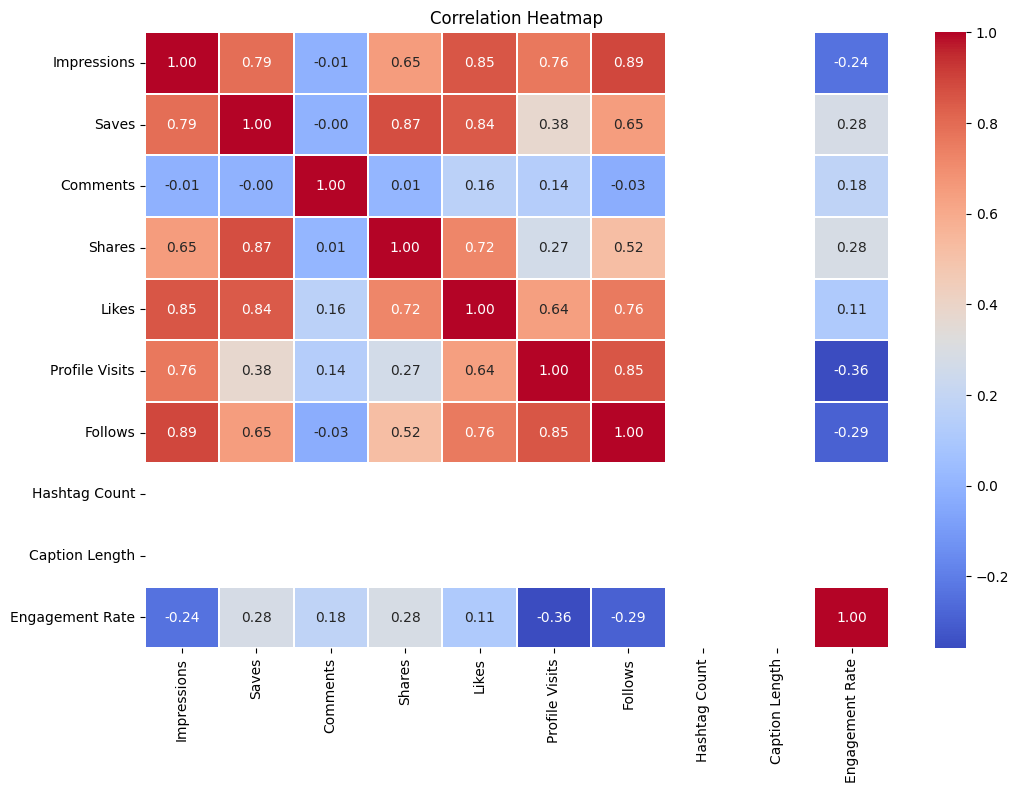

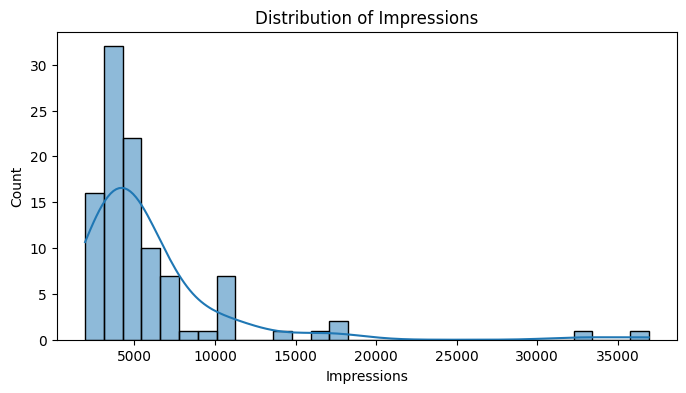

In [ ]:
# Summary stats

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.3)
plt.title('Correlation Heatmap')
plt.show()

# Distribution of target variable
plt.figure(figsize=(8,4))
sns.histplot(df_clean['Impressions'], kde=True, bins=30)
plt.title('Distribution of Impressions')
plt.show()


In [ ]:
# Features (X) and Target (y)

X = df_clean.drop(columns=['Impressions'])
y = df_clean['Impressions']

# Ensure no non-numeric columns in X
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print("Dropping non-numeric columns:", non_numeric)
    X = X.drop(columns=non_numeric)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Scaling (needed for Linear Regression and SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train shape: (81, 9)
Test shape: (21, 9)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
results_data = []
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_scaled)

results_data.append({
    'Model':'Linear Regressor',
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr)
})
print(f"Linear Regression → RMSE: {rmse_lr:.2f}, R²: {r2_lr:.4f}")


Linear Regression → RMSE: 2322.30, R²: 0.8906


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
results_data.append({
    'Model':'Random Forest',
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf)
})
print(f"Random Forest → RMSE: {rmse_rf:.2f}, R²: {r2_rf:.4f}")


Random Forest → RMSE: 2601.25, R²: 0.8628


In [ ]:
from xgboost import XGBRegressor

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)  # NOTE: XGBoost prefers raw (unscaled) data

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
results_data.append({
    'Model':'XGBoost',
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb)
})

print(f"XGBoost → RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.4f}")


XGBoost → RMSE: 2279.18, R²: 0.8947


In [ ]:
from sklearn.svm import SVR

# Train SVR
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Predict
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate
results_data.append({
    'Model':'SVR',
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_svr)),
    'R2': r2_score(y_test, y_pred_svr)
})

print(f"SVR → RMSE: {rmse_svr:.2f}, R²: {r2_svr:.4f}")


SVR → RMSE: 7964.05, R²: -0.2863


,Model,RMSE,R2
0,XGBoost,2279.176715,0.894653
1,Linear Regressor,2322.295093,0.890630
2,Random Forest,2601.253703,0.862776
3,SVR,7964.053559,-0.286272


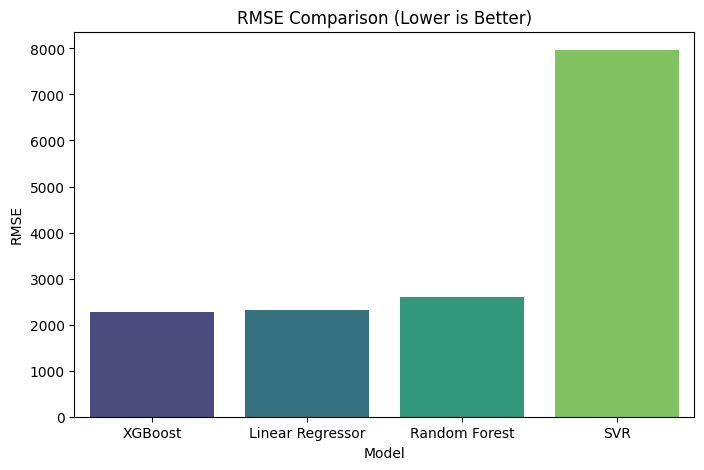

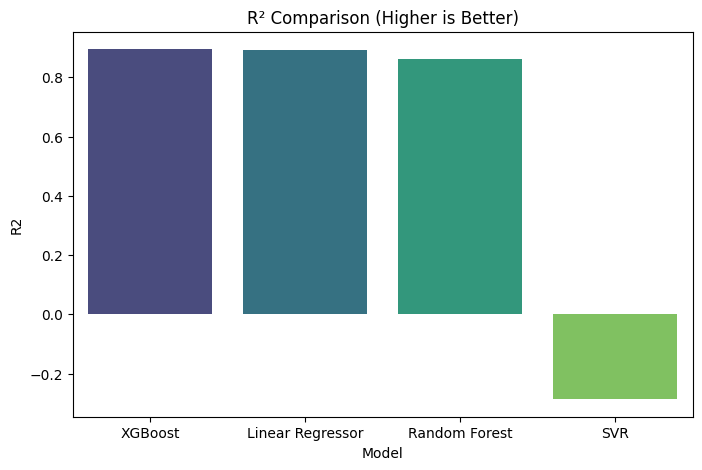

In [ ]:
results_df = pd.DataFrame(results_data).sort_values(by='RMSE').reset_index(drop=True)
display(results_df)

# RMSE Plot
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='RMSE', palette='viridis')
plt.title('RMSE Comparison (Lower is Better)')
plt.show()

# R2 Plot
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='R2', palette='viridis')
plt.title('R² Comparison (Higher is Better)')
plt.show()


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# XGBoost prefers raw features, so use unscaled data here
X_train_raw, X_test_raw = X_train, X_test

# Simplified parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42, verbosity=0)

# Grid search with RMSE scoring
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',  # FIX: Use RMSE directly
    verbose=2,
    n_jobs=-1
)

# Run search
grid_search.fit(X_train_raw, y_train)

# Best parametAers and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE (CV):", -grid_search.best_score_)

# Best model
best_xgb = grid_search.best_estimator_

# Evaluate on test set
y_pred_best = best_xgb.predict(X_test_raw)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Tuned XGBoost -> RMSE: {rmse_best:.2f}, R2: {r2_best:.4f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
Best RMSE (CV): 3478.9146728515625
Tuned XGBoost -> RMSE: 1867.97, R2: 0.9292


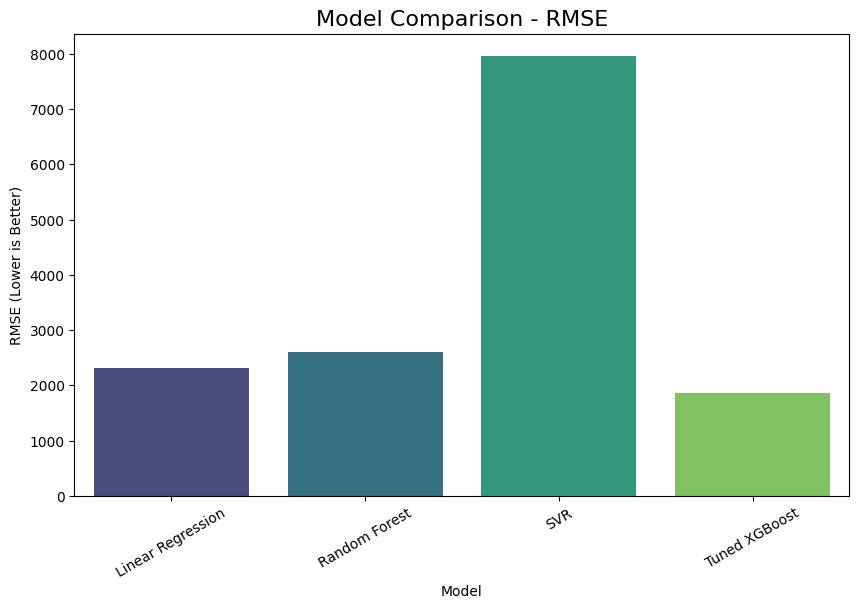

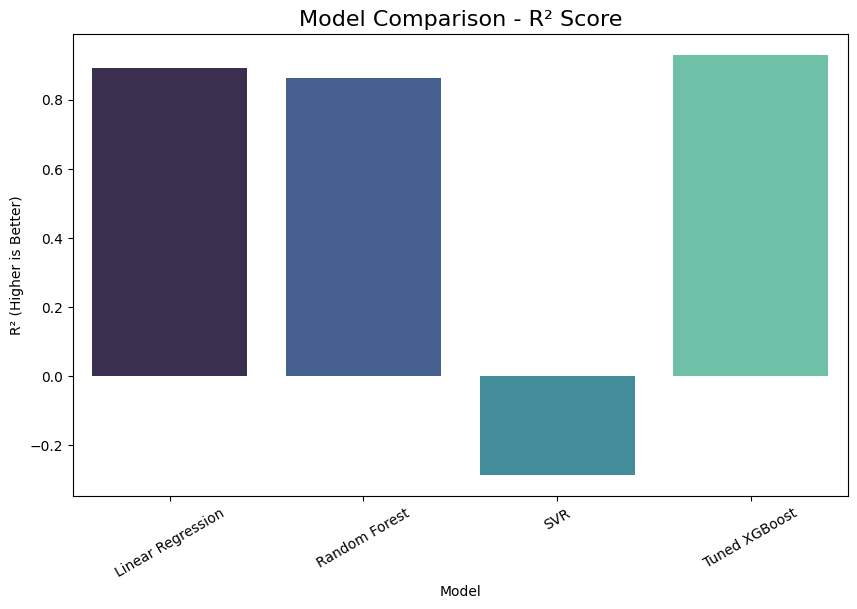

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Final comparison table
results_data = {
    'Model': ['Linear Regression', 'Random Forest', 'SVR', 'Tuned XGBoost'],
    'RMSE': [2322.29, 2601.25, 7964.05, 1867.97],
    'R2': [0.8906, 0.8628, -0.2863, 0.9292]
}

results_df = pd.DataFrame(results_data)

# Bar plot for RMSE
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='Model', y='RMSE', palette='viridis')
plt.title('Model Comparison - RMSE', fontsize=16)
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=30)
plt.show()

# Bar plot for R2
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='Model', y='R2', palette='mako')
plt.title('Model Comparison - R² Score', fontsize=16)
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=30)
plt.show()


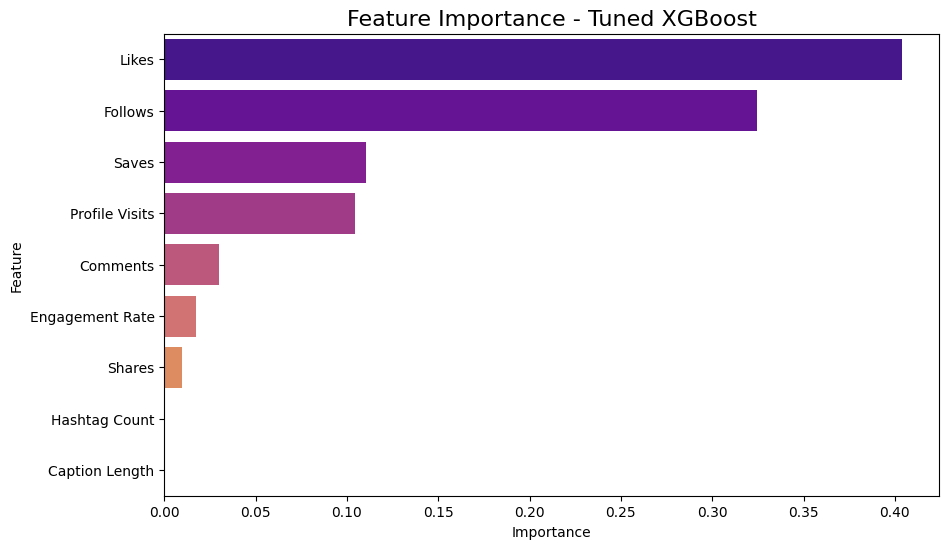

In [ ]:
import numpy as np

# Get feature importance
feature_importances = best_xgb.feature_importances_
features = X_train.columns

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='plasma')
plt.title('Feature Importance - Tuned XGBoost', fontsize=16)
plt.show()


In [ ]:
import joblib

# Save the trained model
joblib.dump(best_xgb, "tuned_xgboost_instagram_model.pkl")
print("Model saved as tuned_xgboost_instagram_model.pkl")
#model = joblib.load("tuned_xgboost_instagram_model.pkl")



Model saved as tuned_xgboost_instagram_model.pkl


In [ ]:
# Save cleaned dataset
df_clean.to_csv("clean_instagram_data.csv", index=False)

# Save results table
results_df.to_csv("model_comparison_results.csv", index=False)


In [ ]:
import numpy as np
import pandas as pd
import joblib

# Load the trained model and scaler
model = joblib.load("/content/tuned_xgboost_instagram_model (1).pkl")
scaler = joblib.load("/content/scaler (1).pkl")

# Define function to take user input
def get_user_input():
    print("Enter the following metrics for a new Instagram post:")
    saves = float(input("Saves: "))
    comments = float(input("Comments: "))
    shares = float(input("Shares: "))
    likes = float(input("Likes: "))
    profile_visits = float(input("Profile Visits: "))
    follows = float(input("Follows: "))
    hashtag_count = float(input("Hashtag Count: "))
    caption_length = float(input("Caption Length: "))
    engagement_rate =float(input("engaemente rate: "))

    # Create DataFrame
    user_df = pd.DataFrame({
        'Saves': [saves],
        'Comments': [comments],
        'Shares': [shares],
        'Likes': [likes],
        'Profile Visits': [profile_visits],
        'Follows': [follows],
        'Hashtag Count': [hashtag_count],
        'Caption Length': [caption_length],
        'Engagement Rate': [engagement_rate]
    })

    return user_df

# Get user input
user_input_df = get_user_input()
# Make prediction
predicted_impressions = model.predict(user_input_df)
print(f"\nPredicted Impressions for this post: {predicted_impressions[0]:.0f}")


Enter the following metrics for a new Instagram post:
Saves: 50
Comments: 0
Shares: 50
Likes: 50
Profile Visits: 0
Follows: 50
Hashtag Count: 50
Caption Length: 50
engaemente rate: 0.0

Predicted Impressions for this post: 7443
